In [ ]:
!pip install pytorch-lightning==1.6.3 --quiet
!pip install transformers==4.19.2 --quiet
!pip install farasapy==0.0.12 --quiet
!pip install PyArabic==0.6.14 --quiet
!pip install torchtext
!pip install arabert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.0/584.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186459 sha256=c7287113cb28cccff8da1334a3d9e302f1d0ccfc68e54f365e29363ef6c2a8a0
  Stored in directory: /root/.cache/pip/wheels/10/f0/fd/4813b1177405693e8da9cdea839f0fb64fde161380e058c827
Successfully built emoji


In [ ]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import re
import os
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from arabert.preprocess import ArabertPreprocessor
from torchtext.data import metrics
from torchtext.data import utils
from torchtext.data import functional
import torchmetrics
import torch.nn as nn
from sklearn.metrics import auc, classification_report, multilabel_confusion_matrix
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt

In [ ]:
TrainData_name = 'train_data.csv'
TestData_name = 'test_data.csv'

selectedModel = "aubmindlab/bert-base-arabertv02-twitter"
Ex_name = "AraBert-twitter"


In [ ]:
!nvidia-smi

Thu May  9 10:38:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
! pip install git+https://github.com/PyTorchLightning/pytorch-lightning

  Cloning https://github.com/PyTorchLightning/pytorch-lightning to /tmp/pip-req-build-6h8eka2r
  Running command git clone --filter=blob:none --quiet https://github.com/PyTorchLightning/pytorch-lightning /tmp/pip-req-build-6h8eka2r
  Resolved https://github.com/PyTorchLightning/pytorch-lightning to commit e0307277a03c0822c26b525c1cdfa71425ed0214
  Running command git submodule update --init --recursive -q
  Encountered 22 file(s) that should have been pointers, but weren't:
        .notebooks/course_UvA-DL/01-introduction-to-pytorch.ipynb
        .notebooks/course_UvA-DL/02-activation-functions.ipynb
        .notebooks/course_UvA-DL/03-initialization-and-optimization.ipynb
        .notebooks/course_UvA-DL/04-inception-resnet-densenet.ipynb
        .notebooks/course_UvA-DL/05-transformers-and-MH-attention.ipynb
        .notebooks/course_UvA-DL/06-graph-neural-networks.ipynb
        .notebooks/course_UvA-DL/07-deep-energy-based-generative-models.ipynb
        .notebooks/course_UvA-DL/08-

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10
tqdm.pandas()

In [ ]:
pl.seed_everything(42)

INFO:pytorch_lightning.utilities.seed:Global seed set to 42


42

In [ ]:
!gdown --id 1U2FWYC51mJ-UvJPR4-Pr2UZZ-O7PF5tH #train
!gdown --id 1D4_BFNnwqNy-Ddp8f-VxS3NbpJW6Lwvw #test

!ls

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1U2FWYC51mJ-UvJPR4-Pr2UZZ-O7PF5tH
To: /content/train_data.csv
100% 2.08M/2.08M [00:00<00:00, 126MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1D4_BFNnwqNy-Ddp8f-VxS3NbpJW6Lwvw
To: /content/test_data.csv
100% 525k/525k [00:00<00:00, 112MB/s]
sample_data  test_data.csv  train_data.csv


In [ ]:
df = pd.read_csv(TrainData_name)
test_df = pd.read_csv(TestData_name)

In [ ]:
df.dropna(subset=['text'], inplace=True)
test_df.dropna(subset=['text'], inplace=True)

In [ ]:
df.head()

,Source.Name,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,label,what_is_the_authors_sentiment_feeling_throughout_the_post_as_it_relates_to_mlb_trade_rumors:confidence,what_is_the_authors_sentiment_feeling_throughout_the_post_as_it_relates_to_mlb_trade_rumors_model_annotation,what_is_the_authors_sentiment_feeling_throughout_the_post_as_it_relates_to_mlb_trade_rumors_model_annotation:confidence,...,r_id,region,replycount,retweetcount,sourcename,text,twitterurl,url,viewcount,what_is_the_authors_sentiment_feeling_throughout_the_post_as_it_relates_to_mlb_trade_rumors_gold
0,task 14 report.csv,3569794598,NaN,finalized,5,4/7/2024 16:11,Positive,0.5828,NaN,NaN,...,1124,west,0,0,dataset_tweet-scraper_2024-02-11_13-49-26-742 ...,MENTION هه ترى كلو شوفان وبياض بيض وموزة بس اق...,https://twitter.com/aboodyoz/status/1248139828...,https://x.com/aboodyoz/status/1248139828484505600,NaN,NaN
1,Task 1 report.csv,3560628953,False,finalized,3,3/20/2024 19:30,Positive,1.0000,NaN,NaN,...,178,eastern,0,1,dataset_tweet eastern 1.xlsx,فديو ركضة الجمعة الصباحية لفريق عدائي الاحساء ...,https://twitter.com/AhsaRunners/status/1656911...,https://x.com/AhsaRunners/status/1656911488630...,497.0,NaN
2,task 17 report.csv,3575557226,NaN,finalized,3,4/17/2024 7:20,Positive,1.0000,NaN,NaN,...,1476,west,0,0,dataset_tweet-scraper_2024-02-11_13-53-54-731 ...,تمرين الصباح يعطيك طاقه لباقي اليوم,https://twitter.com/_mtw71/status/137101780356...,https://x.com/_mtw71/status/1371017803566878722,NaN,NaN
3,task 14 report.csv,3569794535,NaN,finalized,3,4/7/2024 12:22,Positive,0.6780,NaN,NaN,...,1109,west,9,5,dataset_tweet-scraper_2024-02-11_13-49-26-742 ...,الحمد لله ❤️❤️ يوم السبت 13 12 2020 مجموع الخط...,https://twitter.com/ksdoman/status/13382155939...,https://x.com/ksdoman/status/1338215593921671169,NaN,NaN
4,task 16 report.csv,3575529284,NaN,in progress,3,4/17/2024 5:42,Negative,0.6664,NaN,NaN,...,1408,west,3,0,dataset_tweet-scraper_2024-02-11_13-53-54-731 ...,مو جو تمرين والله URL,https://twitter.com/EyadGahwaji/status/1608790...,https://x.com/EyadGahwaji/status/1608790156374...,3700.0,NaN


In [ ]:
df.columns

Index(['Source.Name', '_unit_id', '_golden', '_unit_state',
       '_trusted_judgments', '_last_judgment_at', 'label',
       'what_is_the_authors_sentiment_feeling_throughout_the_post_as_it_relates_to_mlb_trade_rumors:confidence',
       'what_is_the_authors_sentiment_feeling_throughout_the_post_as_it_relates_to_mlb_trade_rumors_model_annotation',
       'what_is_the_authors_sentiment_feeling_throughout_the_post_as_it_relates_to_mlb_trade_rumors_model_annotation:confidence',
       'authorfollowers', 'authorisverified', 'authorname',
       'authorprofilepicture', 'authortwitterurl', 'authorurl',
       'authorusername', 'bookmarkcount', 'content', 'createdat', 'id',
       'likecount', 'media', 'media0', 'media1', 'media2', 'media3', 'media4',
       'quotecount', 'r_id', 'region', 'replycount', 'retweetcount',
       'sourcename', 'text', 'twitterurl', 'url', 'viewcount',
       'what_is_the_authors_sentiment_feeling_throughout_the_post_as_it_relates_to_mlb_trade_rumors_gold'],
    

In [ ]:
# Prepare dataframe
df = df[['r_id', 'twitterurl','region', 'text', 'label']]
test_df = test_df[['r_id', 'twitterurl','region', 'text', 'label']]
df.head()

,r_id,twitterurl,region,text,label
0,1124,https://twitter.com/aboodyoz/status/1248139828...,west,MENTION هه ترى كلو شوفان وبياض بيض وموزة بس اق...,Positive
1,178,https://twitter.com/AhsaRunners/status/1656911...,eastern,فديو ركضة الجمعة الصباحية لفريق عدائي الاحساء ...,Positive
2,1476,https://twitter.com/_mtw71/status/137101780356...,west,تمرين الصباح يعطيك طاقه لباقي اليوم,Positive
3,1109,https://twitter.com/ksdoman/status/13382155939...,west,الحمد لله ❤️❤️ يوم السبت 13 12 2020 مجموع الخط...,Positive
4,1408,https://twitter.com/EyadGahwaji/status/1608790...,west,مو جو تمرين والله URL,Negative


In [ ]:
# Label mapping
#mapping = {'Positive': 0, 'Negative': 1, 'Neutral': 2,'Not_related': 3 }
mapping = {'Positive': 0, 'Negative': 1, 'Neutral': 2} #without not related

df['label'] = df['label'].apply(lambda x: mapping[x])
test_df['label'] = test_df['label'].apply(lambda x: mapping[x])

In [ ]:
LABEL_COLUMNS=['label']
#class_names = ['Positive','Negative','Neutral', 'Not_related']
class_names = ['Positive','Negative','Neutral'] #without not related

In [ ]:
df.head()

,r_id,twitterurl,region,text,label
0,1124,https://twitter.com/aboodyoz/status/1248139828...,west,MENTION هه ترى كلو شوفان وبياض بيض وموزة بس اق...,0
1,178,https://twitter.com/AhsaRunners/status/1656911...,eastern,فديو ركضة الجمعة الصباحية لفريق عدائي الاحساء ...,0
2,1476,https://twitter.com/_mtw71/status/137101780356...,west,تمرين الصباح يعطيك طاقه لباقي اليوم,0
3,1109,https://twitter.com/ksdoman/status/13382155939...,west,الحمد لله ❤️❤️ يوم السبت 13 12 2020 مجموع الخط...,0
4,1408,https://twitter.com/EyadGahwaji/status/1608790...,west,مو جو تمرين والله URL,1


In [ ]:
df['label'].value_counts()

label
0    2428
1     310
2     136
Name: count, dtype: int64

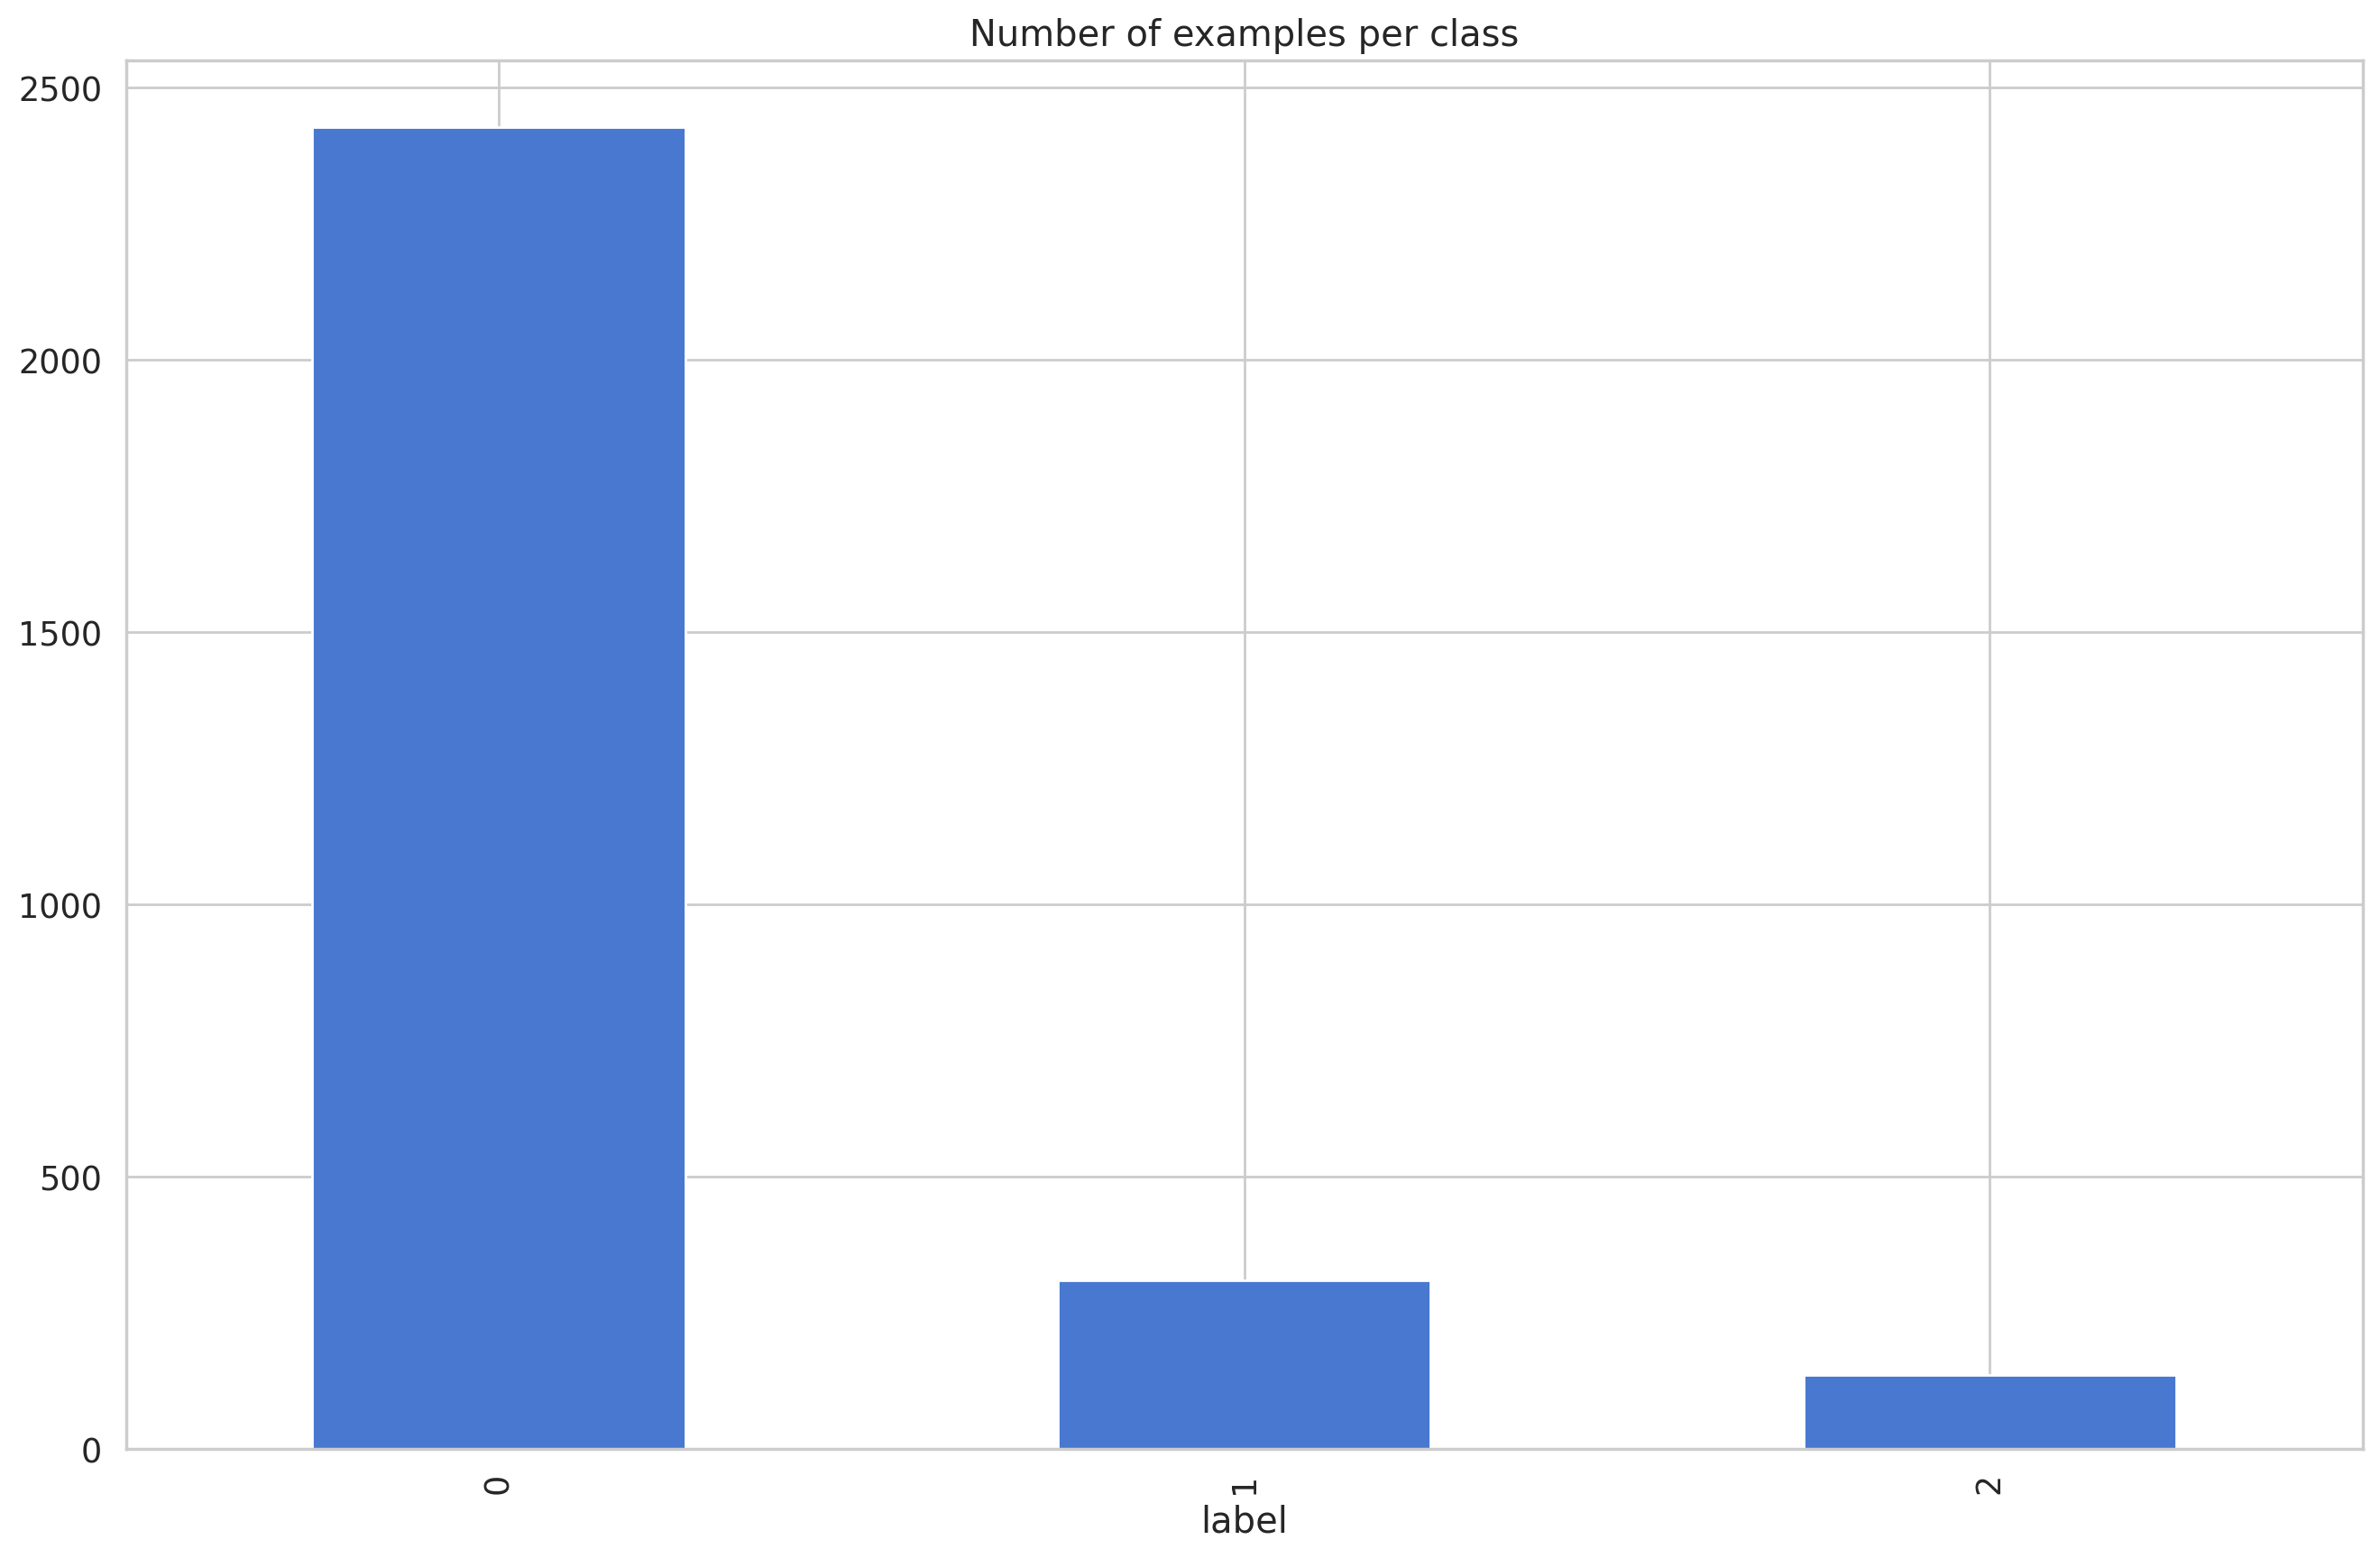

In [ ]:
df['label'].value_counts().sort_values(ascending=False).plot(kind="bar")
plt.title("Number of examples per class");

In [ ]:
!git clone https://github.com/aub-mind/arabert/

Cloning into 'arabert'...
remote: Enumerating objects: 600, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 600 (delta 38), reused 45 (delta 30), pack-reused 535
Receiving objects: 100% (600/600), 9.14 MiB | 18.43 MiB/s, done.
Resolving deltas: 100% (339/339), done.


In [ ]:
model_name = "bert-base-arabertv02"

In [ ]:
print(df.shape)
print(test_df.shape)

(2874, 5)
(719, 5)


In [ ]:
arabert_prep = ArabertPreprocessor(model_name=selectedModel)

In [ ]:
sample_tweet = df.iloc[0]
sample_tweet

r_id                                                       1124
twitterurl    https://twitter.com/aboodyoz/status/1248139828...
region                                                     west
text          MENTION هه ترى كلو شوفان وبياض بيض وموزة بس اق...
label                                                         0
Name: 0, dtype: object

In [ ]:
sample_tweet.text

'MENTION هه ترى كلو شوفان وبياض بيض وموزة بس اقصد ٧٠٠ كالوريز بس'

In [ ]:
sample_text = arabert_prep.preprocess(sample_tweet.text)
sample_text

'MENTION هه ترى كلو شوفان وبياض بيض وموزة بس اقصد 700 كالوريز بس'

In [ ]:
df['text'] = df['text'].progress_apply(arabert_prep.preprocess)
test_df['text'] = test_df['text'].progress_apply(arabert_prep.preprocess)

  0%|          | 0/2874 [00:00<?, ?it/s]

  0%|          | 0/719 [00:00<?, ?it/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(selectedModel)
model = AutoModel.from_pretrained(selectedModel)

Downloading:   0%|          | 0.00/476 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/733k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.19M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/667 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/516M [00:00<?, ?B/s]

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02-twitter were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02-twitter and are newly initialized: ['bert.pooler.dens

In [ ]:
encoding = tokenizer.encode_plus(
  sample_text,
  add_special_tokens=True,
  max_length=128,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
encoding['input_ids'].shape , encoding['attention_mask'].shape

(torch.Size([1, 128]), torch.Size([1, 128]))

In [ ]:
encoding['input_ids'].squeeze()[:20]

tensor([    2,    50, 53960,   242,   245, 47596,   138,   195,  4989,   459,
          185, 31917,   303,  9687,   457, 32048, 48563,   197,  1841, 55938])

In [ ]:
encoding['attention_mask'].squeeze()[:20]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'].squeeze()[:20]))

['[CLS]', 'M', '##EN', '##T', '##I', '##ON', 'ه', '##ه', 'ترى', 'كل', '##و', 'شوف', '##ان', 'وبي', '##اض', 'بيض', 'وموز', '##ة', 'بس', 'اقصد']


In [ ]:
output = model(encoding["input_ids"], encoding["attention_mask"])

In [ ]:
output.last_hidden_state.shape, output.pooler_output.shape

(torch.Size([1, 128, 768]), torch.Size([1, 768]))

In [ ]:
#test_size=0.12 because we are taking 17% of 85% of training data (.18*.85*100=15%)
train_df, val_df = train_test_split(df, test_size=0.18, stratify=df['label'])

In [ ]:
df.shape, train_df.shape, val_df.shape, test_df.shape

((2874, 5), (2356, 5), (518, 5), (719, 5))

In [ ]:
token_counts = []

for _, row in train_df.iterrows():
  token_count = len(tokenizer.encode(str(row.text), max_length=512, truncation=True))
  token_counts.append(token_count)

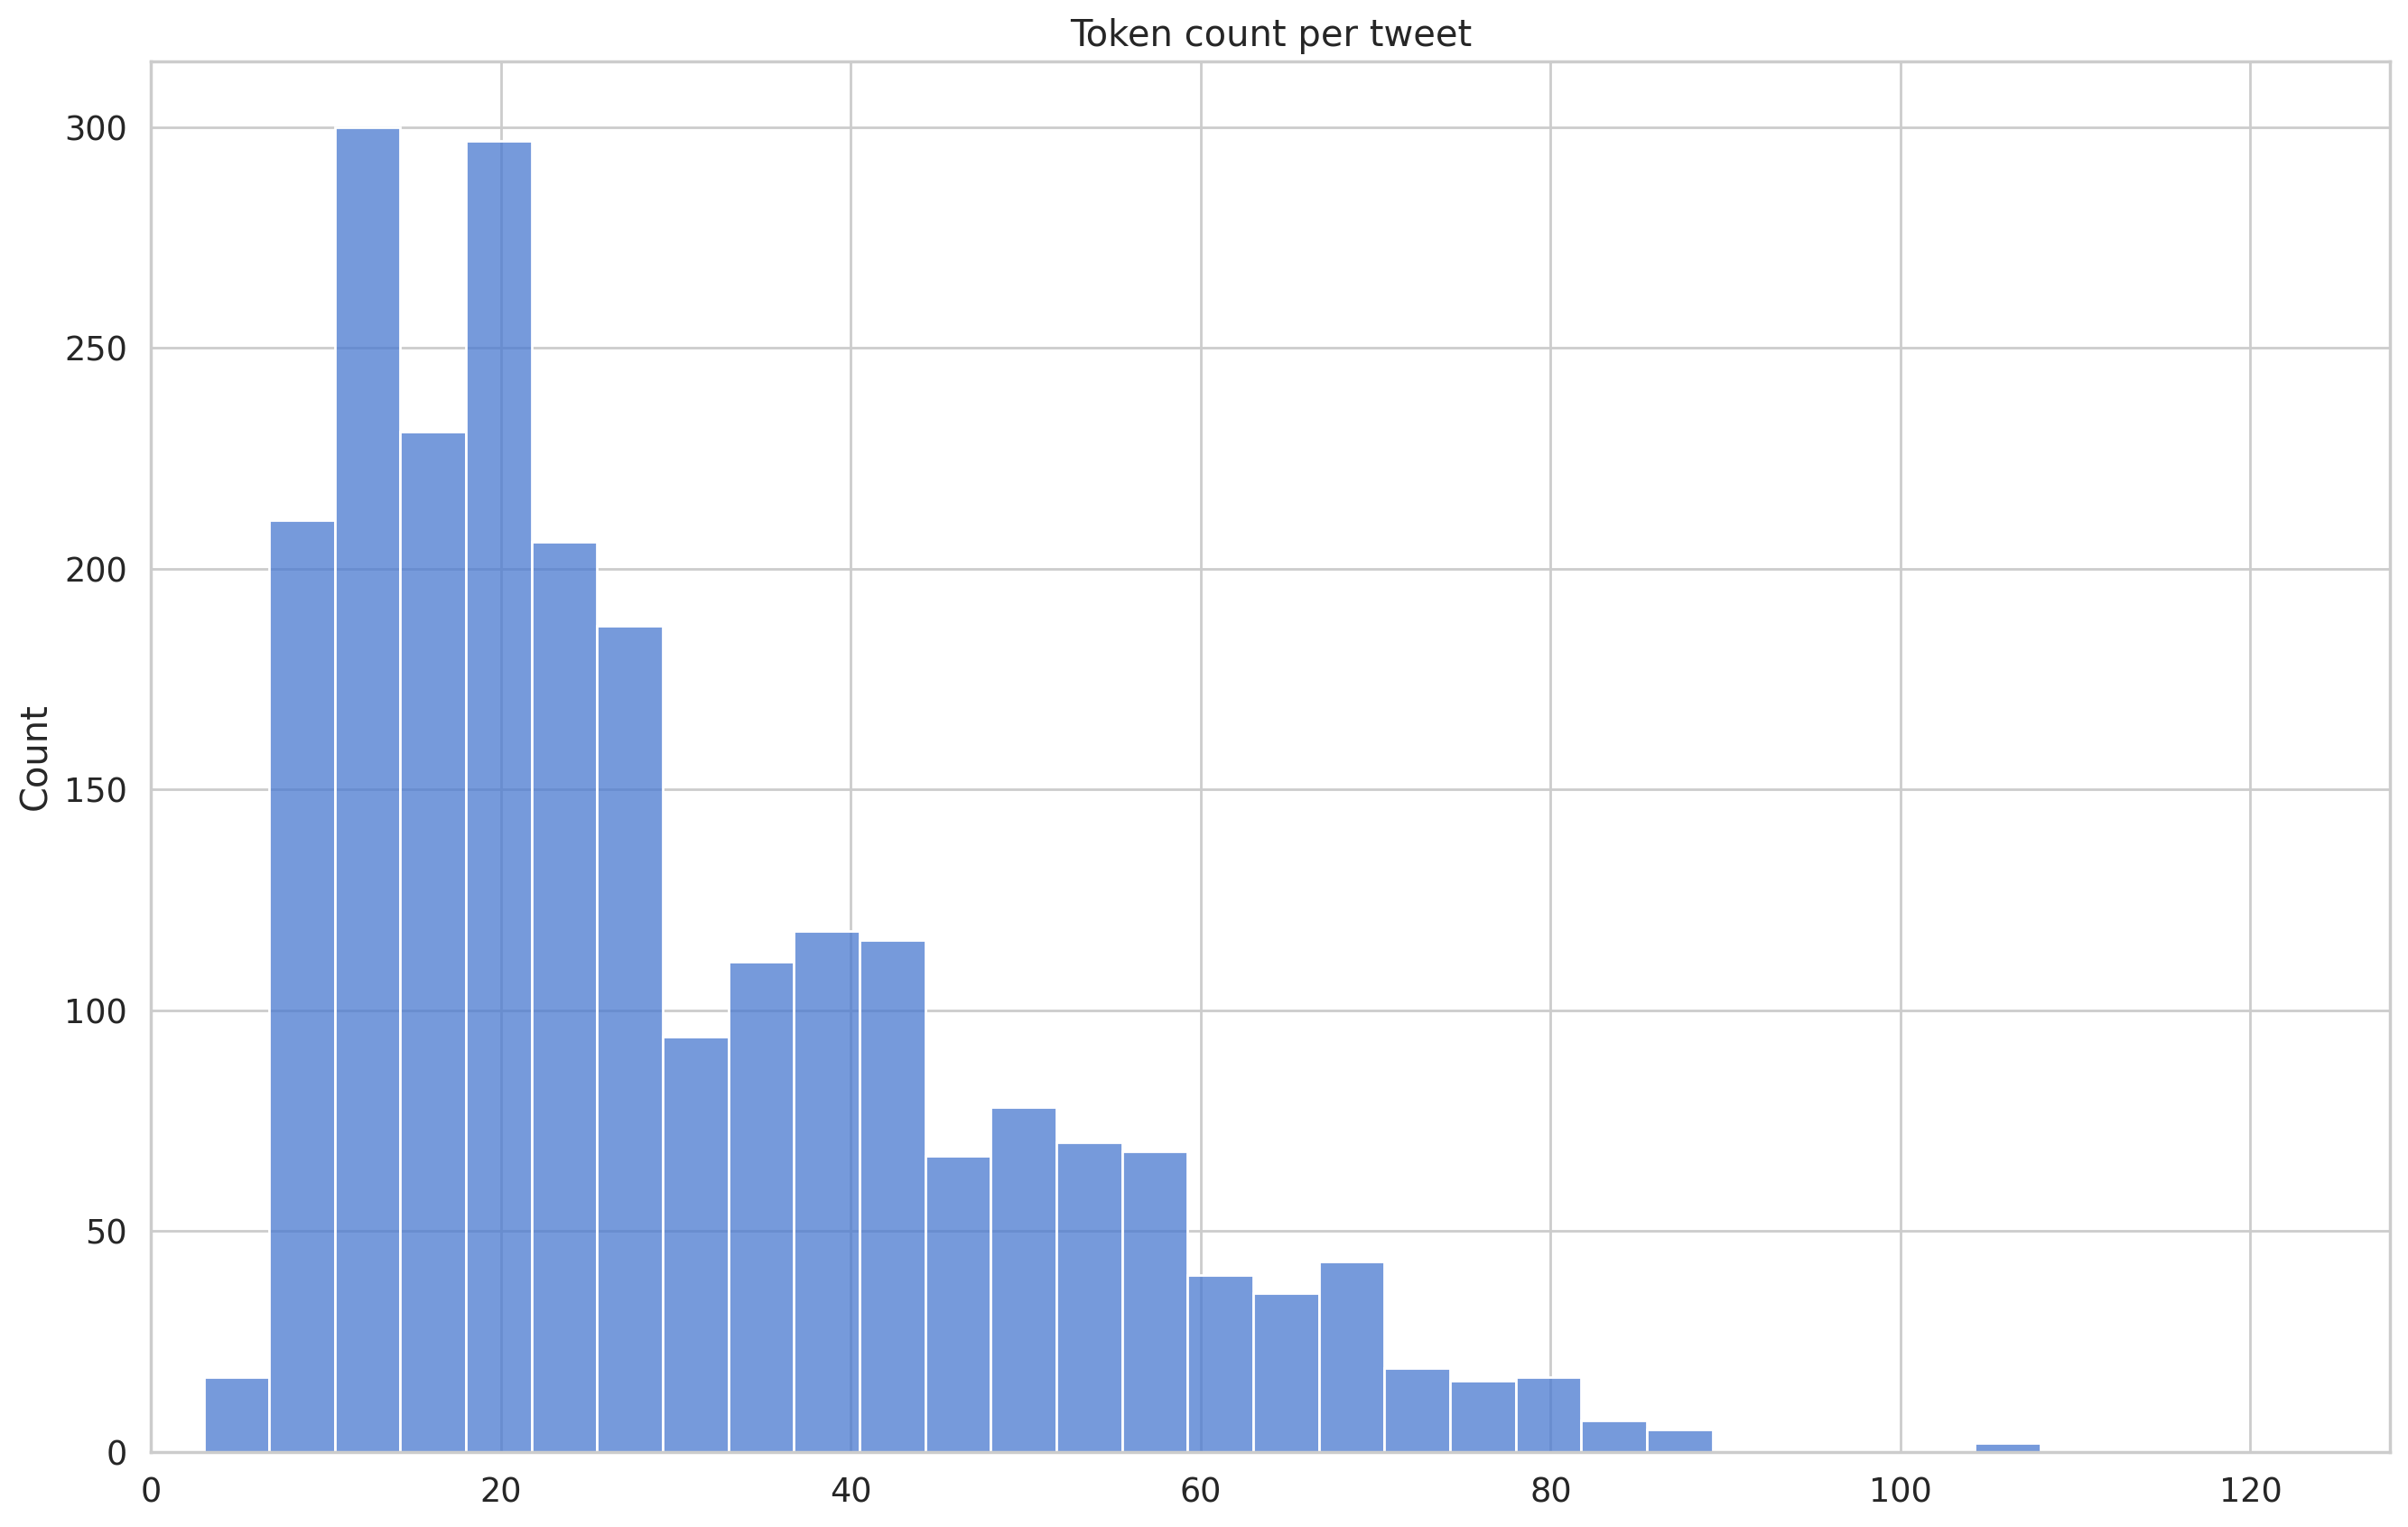

In [ ]:
sns.histplot(token_counts)
plt.xlim([0, 128]);
plt.title("Token count per tweet");

In [ ]:
MAX_TOKEN_COUNT = 128

In [ ]:
class TweetEmotionDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: AutoTokenizer,
        text_preprocessor=None,
        max_token_len: int = MAX_TOKEN_COUNT
    ):
        self.data = data
        self.tokenizer = tokenizer
        self.text_preprocessor = text_preprocessor
        self.max_token_len = max_token_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]

        text = data_row.text
        if self.text_preprocessor is not None:
            text = self.text_preprocessor.preprocess(text)

        encoding = self.tokenizer.encode_plus(
            text=text,
            add_special_tokens=True,
            max_length=self.max_token_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            "text": text,
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(data_row.label, dtype=torch.long)
        }

In [ ]:
train_dataset = TweetEmotionDataset(train_df, tokenizer, max_token_len=MAX_TOKEN_COUNT)

## to be sure every thing is going right:
print (len(train_dataset) == len(train_df))

True


In [ ]:
print(type(train_dataset))

<class '__main__.TweetEmotionDataset'>


In [ ]:
sample_item = train_dataset[50]

In [ ]:
sample_item.keys()

dict_keys(['text', 'input_ids', 'attention_mask', 'labels'])

In [ ]:
print(sample_item['input_ids'].shape)
print(sample_item['attention_mask'].shape)

torch.Size([128])
torch.Size([128])


In [ ]:
sample_item["text"]

'وانا في ال يم اليوم gym URL'

In [ ]:
sample_item["labels"]

tensor(0)

In [ ]:
class TweetDataModule(pl.LightningDataModule):

  def __init__(
      self,
      train_df,
      val_df,
      test_df,
      tokenizer,
      text_preprocessor=None,
      batch_size=8,
      token_len=128
    ):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.text_preprocessor = text_preprocessor
    self.token_len = token_len

  def setup(self, stage=None):
    self.train_dataset = TweetEmotionDataset(
      self.train_df,
      self.tokenizer,
      self.text_preprocessor,
      self.token_len
    )

    self.val_dataset = TweetEmotionDataset(
      self.val_df,
      self.tokenizer,
      self.text_preprocessor,
      self.token_len
    )

    self.test_dataset = TweetEmotionDataset(
      self.test_df,
      self.tokenizer,
      self.text_preprocessor,
      self.token_len
    )

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=os.cpu_count()
    )


  def val_dataloader(self):
    return DataLoader(self.val_dataset, batch_size=1, num_workers=os.cpu_count())

  def test_dataloader(self):
    return DataLoader(self.test_dataset, batch_size=1, num_workers=os.cpu_count())

In [ ]:
N_EPOCHS = 30
BATCH_SIZE = 32

data_module = TweetDataModule(train_df, val_df, test_df, tokenizer, batch_size=BATCH_SIZE, token_len=MAX_TOKEN_COUNT)
data_module.setup()

In [ ]:
for batch in data_module.train_dataloader():
  print(len(batch))
  print(batch["input_ids"].shape, batch["attention_mask"].shape)
  print(batch["labels"].shape)
  print("_____________________________________________________________________________________________________________")
  print(batch)
  break

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


4
torch.Size([32, 128]) torch.Size([32, 128])
torch.Size([32])
_____________________________________________________________________________________________________________
{'text': ['لازم نفهم المعضلين انو تمرين مو ركعة الوتر لان وضعهم صاير او ر', 'اخطاء بسيطة في بدايتها تمهد لامراض عديدة على سنوات ❌ النوم بعد الاكل مباشرة اقل شي ساعتين ❌ الاكل حتى التخمة ❌ الاستلقاء بعد الاكل ولو بدون نوم ❌ عدم ممارسة رياضة المشي بعد الوجبات الثقيلة خاصة ❌ الاكثار من السوائل مع الاكل ❌ اهمال زيادة الوزن في بدايتها دهون الكبد', 'MENTION جربي رجيم البروتين تنسد شهيتك بدون اي حبوب', 'MENTION MENTION هبد المكملات مايخلص خصوصا في الجيم تسمع اشياء مانزل الله بها من سلطان بلاسيبو افكت مسوي شغله معهم', 'تمارين الكارديو لشد الجسم و نحته URL', 'انواع تمارين بلايومتري URL', 'حتى ونسبة الاوكسجين هنا 33 ومافيه هواء نقي نسوي كارديو URL', 'صباح الخير بعد احلى كارديو صباحي مع الوالد', 'صباحكم نشاط URL', 'عشوائيات ال gym URL', 'تمرين اليوم رهيب فيه اوزان محترمة وكارديو محترم وتغذية محترمة \u200d بس شفت واحد حاولت اتج

In [ ]:
class TweetPredictor(pl.LightningModule):

    def __init__(self, n_classes: list, steps_per_epoch=None, n_epochs=None):
        super().__init__()
        self.bert = AutoModel.from_pretrained(selectedModel, return_dict=True)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.steps_per_epoch = steps_per_epoch
        self.n_epochs = n_epochs
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids, attention_mask=attention_mask)
        output = self.classifier(output.pooler_output)
        output = torch.softmax(output, dim=1)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return {"loss": loss, "predictions": outputs, "labels": labels}

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=2e-5)
        warmup_steps = self.steps_per_epoch // 3
        total_steps = self.steps_per_epoch * self.n_epochs - warmup_steps
        scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)
        return [optimizer], [scheduler]

    def lr_scheduler_step(self, *args, **kwargs):
        pass

In [ ]:
data_module = TweetDataModule(train_df, val_df, test_df, tokenizer, batch_size=BATCH_SIZE, token_len=MAX_TOKEN_COUNT)
data_module.setup()
model = TweetPredictor(n_classes=3, steps_per_epoch=len(train_df) // BATCH_SIZE, n_epochs=N_EPOCHS)

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02-twitter were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02-twitter and are newly initialized: ['bert.pooler.dens

In [ ]:
!rm -rf lightning_logs

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

In [ ]:
from pytorch_lightning.callbacks import LearningRateMonitor
scheduler = LearningRateMonitor(logging_interval='step')

#1
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

#2
logger = TensorBoardLogger("lightning_logs", name="tweet-label")

In [ ]:
trainer = pl.Trainer(
    logger=logger,
    enable_checkpointing=checkpoint_callback,
    max_epochs=N_EPOCHS,
    gpus=1,
    enable_progress_bar=True,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data_module)

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params
------------------------------------------------
0 | bert       | BertModel        | 135 M 
1 | classifier | Linear           | 2.3 K 
2 | criterion  | CrossEntropyLoss | 0     
------------------------------------------------
135 M     Trainable params
0         Non-trainable params
135 M     Total params
540.783   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
trainer.test(datamodule=data_module)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/trainer.py:1444: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/tweet-label/version_0/checkpoints/epoch=29-step=2220.ckpt
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at lightning_logs/tweet-label/version_0/checkpoints/epoch=29-step=2220.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.9385005235671997     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.9385005235671997}]

In [ ]:
ls lightning_logs/tweet-label/version_0/checkpoints/

'epoch=29-step=2220.ckpt'


In [ ]:
trained_model = TweetPredictor.load_from_checkpoint("lightning_logs/tweet-label/version_0/checkpoints/epoch=29-step=2220.ckpt", n_classes=3)
trained_model.freeze()

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02-twitter were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02-twitter and are newly initialized: ['bert.pooler.dens

In [ ]:
def predict(text, model, tokenizer):

  encoding = tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=128,
    return_token_type_ids=False,
    padding="max_length",
    return_attention_mask=True,
    return_tensors='pt',
  )

  _, prediction_prop = model(encoding["input_ids"], encoding["attention_mask"])
  print("prediction_prop: ",prediction_prop)
  prediction = torch.max(prediction_prop, dim=1)
  print("prediction: ",prediction)

  return prediction

In [ ]:
sample_tweet = val_df.iloc[50]
sample_tweet

r_id                                                       1644
twitterurl    https://twitter.com/M_k_z_Alshareef/status/155...
region                                                     west
text                          MENTION من الان اسخن هرولة وسباحة
label                                                         0
Name: 2673, dtype: object

In [ ]:
text = sample_tweet.text
text

'MENTION من الان اسخن هرولة وسباحة'

In [ ]:
sample_prediction = predict(text, trained_model, tokenizer)
print(sample_prediction)

prediction_prop:  tensor([[0.6012, 0.1221, 0.2767]])
prediction:  torch.return_types.max(
values=tensor([0.6012]),
indices=tensor([0]))
torch.return_types.max(
values=tensor([0.6012]),
indices=tensor([0]))


In [ ]:
val_dataset = TweetEmotionDataset(val_df, tokenizer, max_token_len=MAX_TOKEN_COUNT)

In [ ]:
test_dataset = TweetEmotionDataset(test_df, tokenizer, max_token_len=MAX_TOKEN_COUNT)

In [ ]:
import torch.nn.functional as F

In [ ]:
def get_predictions(model, data_loader):

  import torch.nn.functional as F

  texts = []
  predictions = []
  prediction_probs = []
  labels = []


  for item in tqdm(data_loader):

    text = item["text"]
    labels.append(item["labels"])

    _, output = trained_model(item["input_ids"].unsqueeze(dim=0), item["attention_mask"].unsqueeze(dim=0))

    _, preds = torch.max(output, dim=1)
    probs = F.softmax(output, dim=1)

    texts.extend(text) # we can use .append instead of .extend
    predictions.extend(preds)
    prediction_probs.extend(probs)


  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  labels = torch.stack(labels).cpu()

  return texts, predictions, prediction_probs, labels

In [ ]:
val_texts, val_pred, val_pred_probs, val_true = get_predictions(
  trained_model,
  val_dataset
)

  0%|          | 0/518 [00:00<?, ?it/s]

In [ ]:
test_texts, test_pred, test_pred_probs, test_true = get_predictions(
  trained_model,
  test_dataset
)

  0%|          | 0/719 [00:00<?, ?it/s]

In [ ]:
print(val_pred[:10])
print(val_pred_probs[:10])
print(val_true[:10])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([[0.4109, 0.2828, 0.3063],
        [0.4187, 0.2707, 0.3105],
        [0.3825, 0.2989, 0.3185],
        [0.4074, 0.2771, 0.3156],
        [0.4389, 0.2698, 0.2913],
        [0.3795, 0.2801, 0.3404],
        [0.4332, 0.2742, 0.2927],
        [0.3889, 0.3005, 0.3105],
        [0.4368, 0.2731, 0.2901],
        [0.4077, 0.2730, 0.3193]])
tensor([2, 0, 0, 0, 1, 1, 0, 0, 0, 1])


In [ ]:
val_pred.shape, val_true.shape, test_pred.shape, test_true.shape

(torch.Size([518]), torch.Size([518]), torch.Size([719]), torch.Size([719]))

In [ ]:
report_val = classification_report(val_true, val_pred, target_names=class_names, zero_division=0, digits=4)
print(report_val)

              precision    recall  f1-score   support

    Positive     0.8453    0.9977    0.9152       438
    Negative     0.0000    0.0000    0.0000        56
     Neutral     0.0000    0.0000    0.0000        24

    accuracy                         0.8436       518
   macro avg     0.2818    0.3326    0.3051       518
weighted avg     0.7147    0.8436    0.7738       518



In [ ]:
report_test = classification_report(test_true, test_pred, target_names=class_names, zero_division=0, digits=4)
print(report_test)

              precision    recall  f1-score   support

    Positive     0.8595    1.0000    0.9245       618
    Negative     0.0000    0.0000    0.0000        73
     Neutral     0.0000    0.0000    0.0000        28

    accuracy                         0.8595       719
   macro avg     0.2865    0.3333    0.3082       719
weighted avg     0.7388    0.8595    0.7946       719



In [ ]:
!pip install scikit-learn

In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix_val = confusion_matrix(val_pred, val_true)
print(cf_matrix_val)

[[437  56  24]
 [  0   0   0]
 [  1   0   0]]


In [ ]:
cf_matrix_test = confusion_matrix(test_pred, test_true)
print(cf_matrix_test)

[[618  73  28]
 [  0   0   0]
 [  0   0   0]]


(3, 3)


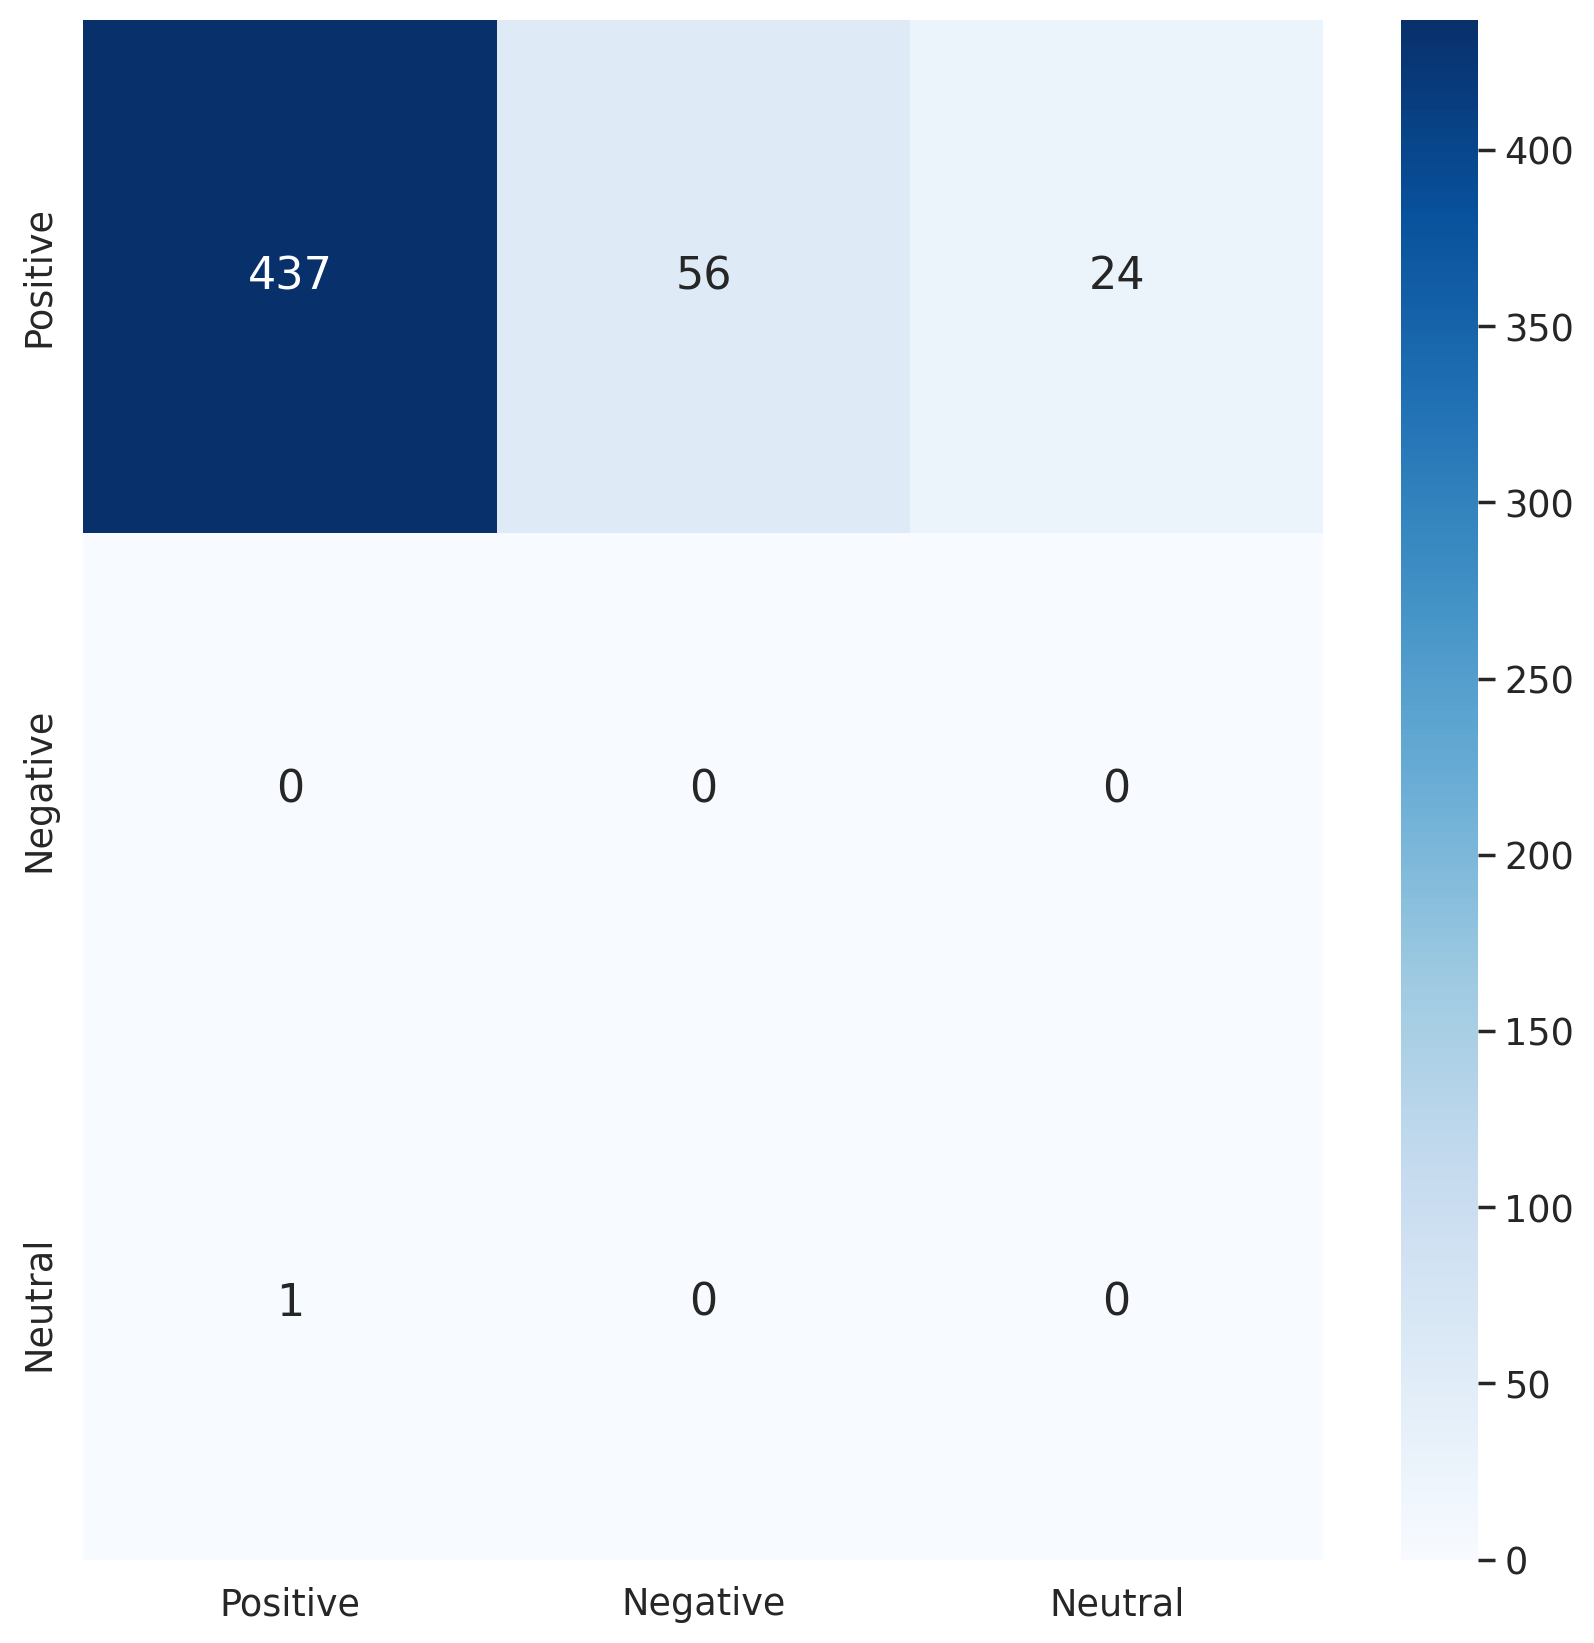

In [ ]:
#visualize confusion matrix for val set

cm_df_val = np.asarray(cf_matrix_val).reshape(3,3)

print(cm_df_val.shape)
plt.figure(figsize = (10,10))
sns.heatmap(cm_df_val, annot=True, fmt='', cmap='Blues',annot_kws={"size": 16}, xticklabels=class_names, yticklabels=class_names)
plt.show()

(3, 3)


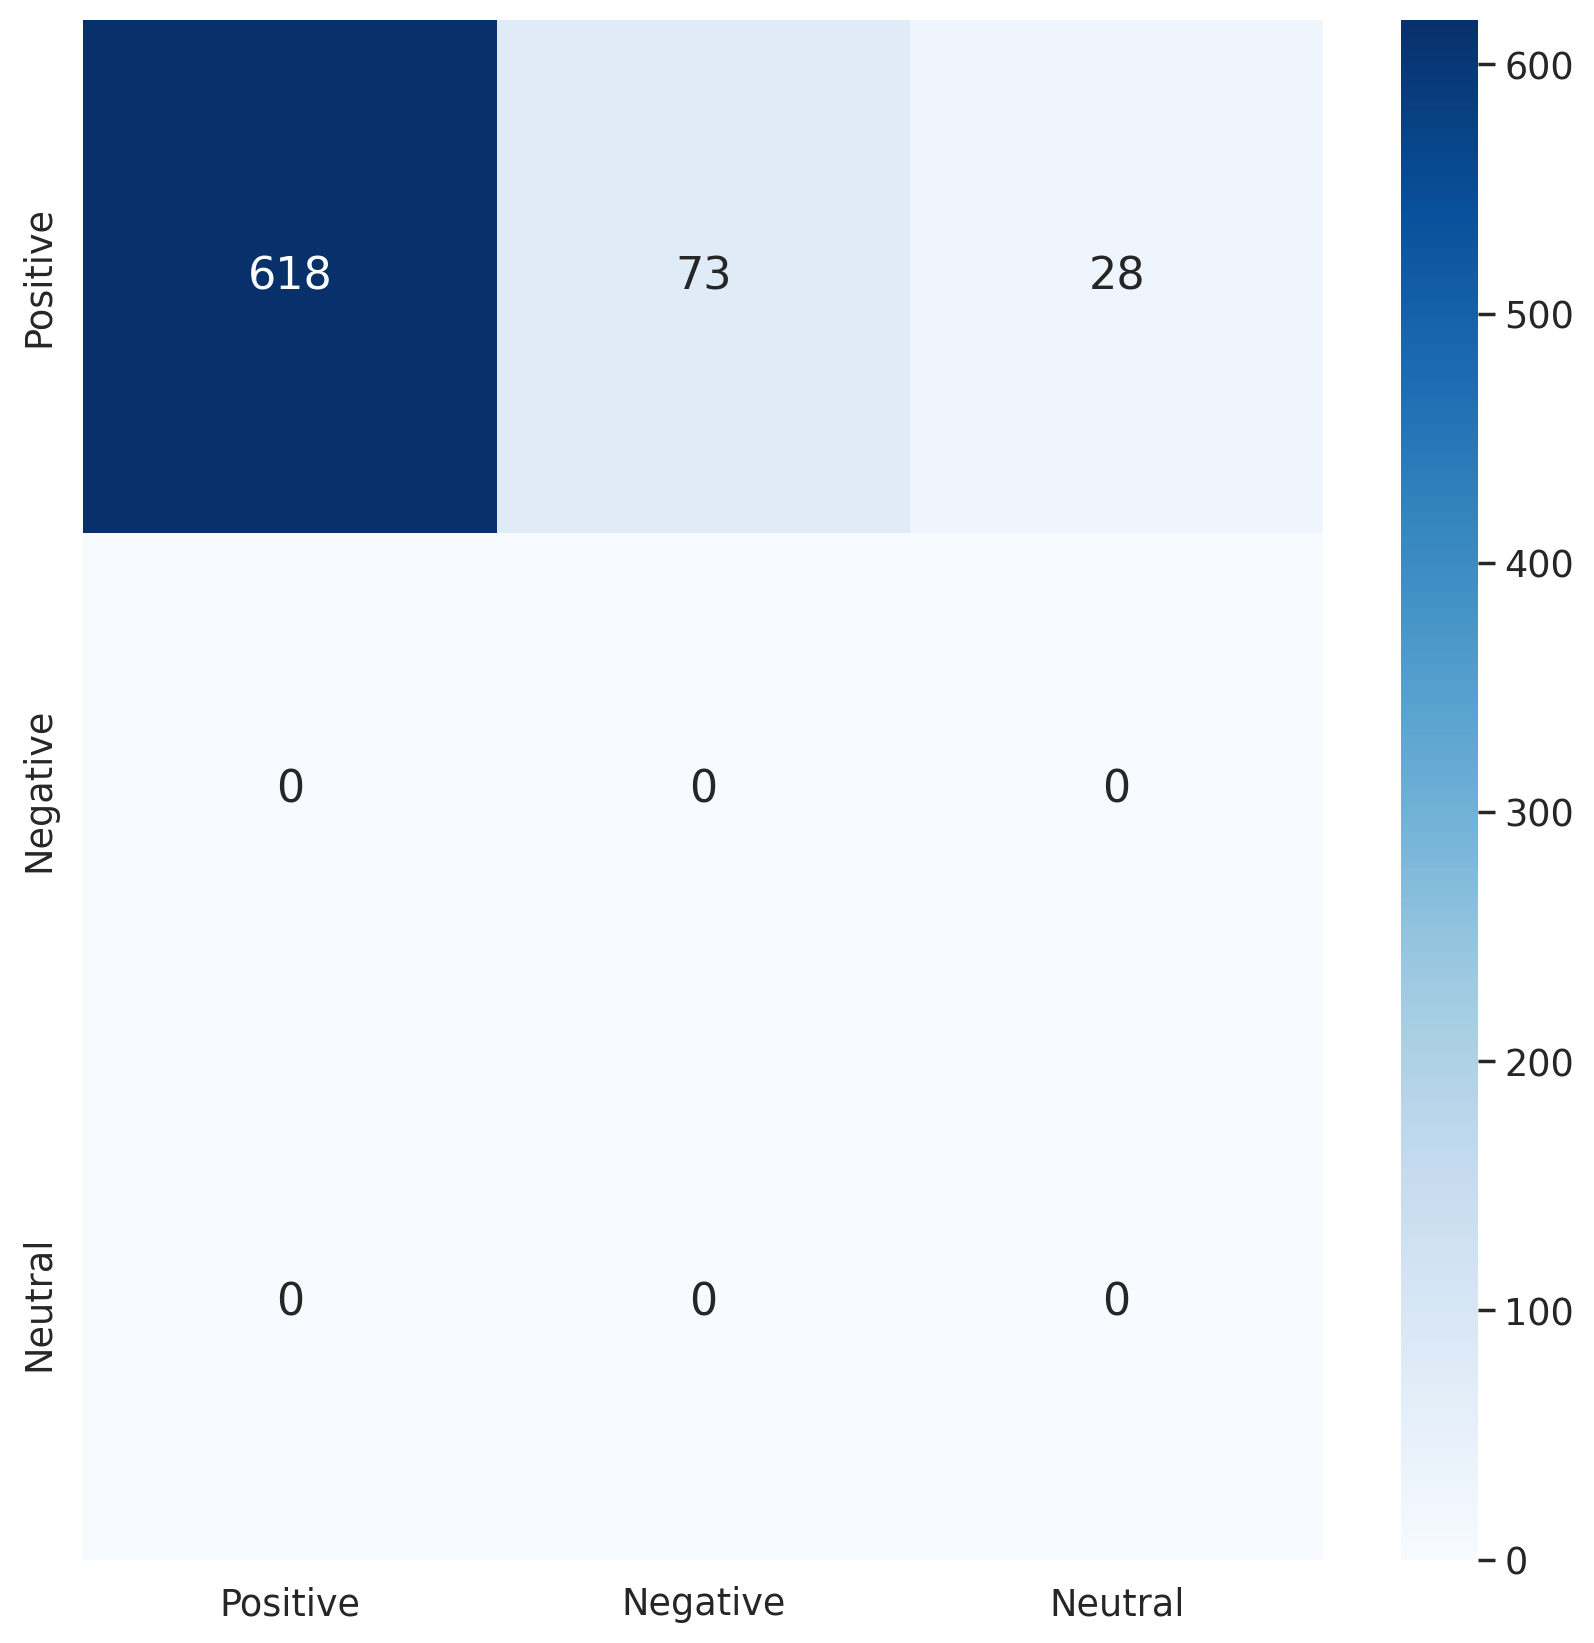

In [ ]:
#visualize confusion matrix for test set

cm_df_test = np.asarray(cf_matrix_test).reshape(3,3)

print(cm_df_test.shape)
plt.figure(figsize = (10,10))
sns.heatmap(cm_df_test, annot=True, fmt='', cmap='Blues',annot_kws={"size": 16}, xticklabels=class_names, yticklabels=class_names)
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change directory to save the results
path = "/content/drive/My Drive/Senior Dataset"
%cd $path

/content/drive/My Drive/Senior Dataset


In [ ]:
val_df['Real_label'] = val_true
val_df['Predicted_label'] = val_pred

test_df['Real_label'] = test_true
test_df['Predicted_label'] = test_pred

val_df.to_csv(Ex_name+'_Val_True&Pred.csv', index = None, header=True)
test_df.to_csv(Ex_name+'_Test_True&Pred.csv', index = None, header=True)

In [ ]:
ex_report_val = classification_report(val_true, val_pred, target_names=class_names, zero_division=0, digits=4, output_dict=True)
ex_report_test = classification_report(test_true, test_pred, target_names=class_names, zero_division=0, digits=4, output_dict=True)

print(ex_report_val)
print(ex_report_test)

df_report_val = pd.DataFrame(ex_report_val).transpose()
df_report_test = pd.DataFrame(ex_report_test).transpose()

df_report_val.to_csv(Ex_name+'_Val_report.csv', sep=',')
df_report_test.to_csv(Ex_name+'_Test_report.csv', sep=',')

{'Positive': {'precision': 0.8452611218568665, 'recall': 0.997716894977169, 'f1-score': 0.9151832460732985, 'support': 438}, 'Negative': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 56}, 'Neutral': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 24}, 'accuracy': 0.8436293436293436, 'macro avg': {'precision': 0.28175370728562216, 'recall': 0.332572298325723, 'f1-score': 0.30506108202443283, 'support': 518}, 'weighted avg': {'precision': 0.7147188636550338, 'recall': 0.8436293436293436, 'f1-score': 0.7738422042086964, 'support': 518}}
{'Positive': {'precision': 0.8595271210013908, 'recall': 1.0, 'f1-score': 0.9244577412116679, 'support': 618}, 'Negative': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 73}, 'Neutral': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 28}, 'accuracy': 0.8595271210013908, 'macro avg': {'precision': 0.2865090403337969, 'recall': 0.3333333333333333, 'f1-score': 0.3081525804038893, 'support': 719}, 'wei